In [ ]:
Simulation code used to gain qualitative insights on the EDET chip's edge conduction and temperature response behavior

Pre-import modules and setup filepaths

In [2]:
%matplotlib ipympl
import simulationlib as sl
import lasinglib as ll
import measurelib as ml

import modulators as mo
import shapes

import numpy as np
import matplotlib.pyplot as plt

import logging
import os

from matplotlib import cm

from scipy.optimize import curve_fit

from tqdm.notebook import tqdm
import multiprocess

from scipy.special import erf

from IPython.display import HTML

os.chdir(os.path.abspath(''))

logging.basicConfig()
logging.getLogger().setLevel(logging.WARNING)

Initialize simulation framework and useful constants

In [3]:
def occlusion(x, w, c):
    '''
    Using a domain-shifted razor blade model, return the proportion of laser power
    that will hit the edge of the chip given a laser with a certain waist and distance from the edge.

    parameters:

    x float, array[float]: The distance from the edge of the chip in millimeters

    w float: The gaussian beam waist w(z) in millimeters of the laser at the point of intersection with the chip.
             Related to FWHM by FWHM = w * sqrt(2 * np.log(2))

    c float: x-offset. Used to tune the position of the exact edge.

    returns:

    beamprop float: a number between 0 and 1 representing the effective laser power after occlusion.

    '''
    return 1 - 0.5 * (1 - erf(((x - c) * (np.sqrt(2)) / w)))

def expmodel(x, a, b, c):
    '''
    Exponential falloff fit function
    '''
    return a * np.exp((x - c) * b)

def beam_falloff(x, a, b, c, w):
    '''
    Function to characterize lasing temperature response falloff w.r.t. distance from an edge
    '''
    return expmodel(x, a, b, c) * occlusion(x, w, c)

def spar(x, boost, w, c, spar_width):
    '''
    Boosts temperature based off of amount of beam hitting spar
    '''
    return 1 + boost * (occlusion(x-c, w, -spar_width / 2) - occlusion(x-c, w, spar_width / 2))

def beam_falloff_spar_independent(x, a, w, edge_offset, boost, spar_width):
    return a * spar(x, boost, w, 16, spar_width) * occlusion(x, -w, edge_offset)

def beam_falloff_spar(y, w, edge_offset, boost, spar_width):
    return spar(y, boost, w, 16, spar_width) * occlusion(x, -w, edge_offset)

def edge_model(x, y, a, b, c, w, edge_offset, boost, spar_width):
    pass

def sub_exp(x, a, b, c, q=0):
    return a * (1 - np.exp((x - c) * b)+ q)

def spar_dampen(x, boost, w, c, spar_width):
    return spar(x, boost, -w, c, spar_width)

def ROI_xmodel(x, a, b, c1, boost, w, c2=17.094255950785502, spar_width=1.09):
    return sub_exp(x, a, b, c1) * occlusion(x, w, c1) * spar_dampen(x, boost, w, c2, spar_width)

In [4]:
SILICON = sl.Material(diffusivity=88, emissivity=0.09, specific_heat=0.7, density=0.002329002)
CHIP = sl.SimGrid(32, 97, 0.03, use_spar=False,
                  spar_thickness=0.5, spar_width=1)

sim = sl.Simulation(CHIP, SILICON, duration=1.5, pulses=None, ambient_temp=300,
                    starting_temp=303, neumann_bc=False, 
                    edge_derivative=0, sample_framerate=0, intended_pbs=1,
                    dense_logging=False, timestep_multi=1, radiation=True, progress_bar=True, silent=True)

print(sim.TIMESTEP)

EXPERIMENTAL_SIGMA = 0.769941159 # beam sigma, mm

CENTER = (CHIP.CENTERPOINT)

0.00030918173122445626


In [50]:
# Create laser pulses of interest and build them into a list
# edge experiment sim
max_temps = []
distances = np.linspace(-3, 5, 40)

edge = ml.MeasureArea(CHIP, (0, 16), lambda x, y: x == 0)
edge_maxtemp = ml.Measurement(edge, modes=["MAX"])
record_edge = ml.Measurer(start_time=0, duration=1.5, measurement=edge_maxtemp, tag="edge maxtemp")

color = iter(cm.rainbow(np.linspace(0, 1, len(distances))))

for d in distances:
    print(f"distance: {d}")
    pulse = ll.LaserPulse(CHIP, start=0, duration=1, position=(d, 22), power=6, sigma=EXPERIMENTAL_SIGMA)
    sim.pulses = [pulse]
    result = sim.simulate(analyzers=[record_edge])
    max_temps.append(result["edge maxtemp MAX 0"])


distance: -3.0
distance: -2.7948717948717947
distance: -2.58974358974359
distance: -2.3846153846153846
distance: -2.1794871794871797
distance: -1.9743589743589745
distance: -1.7692307692307692
distance: -1.564102564102564
distance: -1.358974358974359
distance: -1.153846153846154
distance: -0.9487179487179489
distance: -0.7435897435897436
distance: -0.5384615384615383
distance: -0.3333333333333335
distance: -0.1282051282051282
distance: 0.07692307692307665
distance: 0.28205128205128194
distance: 0.4871794871794872
distance: 0.6923076923076921
distance: 0.8974358974358974
distance: 1.1025641025641022
distance: 1.3076923076923075
distance: 1.5128205128205128
distance: 1.717948717948718
distance: 1.9230769230769234
distance: 2.1282051282051277
distance: 2.333333333333333
distance: 2.5384615384615383
distance: 2.7435897435897436
distance: 2.948717948717949
distance: 3.1538461538461533
distance: 3.3589743589743586
distance: 3.564102564102564
distance: 3.769230769230769
distance: 3.9743589743

Testing and modelling edge temperature response as a function of lasing distance from edge of interest

In [1]:
color = iter(cm.rainbow(np.linspace(0, 1, len(distances))))
distances = np.linspace(-3, 5, 40)
# time = result["edge maxtemp time"]
plt.close(0)
fig, ax = plt.subplots(num=0)
y = np.array([np.max(booga - 303) for booga in max_temps])

def expfitmodel(x, a, b, c):
    return a * np.exp(b * x) + c

def gaussianfitmodel(x, a, b, c):
    return a * np.exp(-(x - b)**2 / (2 * c**2))


params, pcov = curve_fit(beam_falloff, distances, y, p0=(136, -0.3, -2.5, 1.3))
# params2, pcov2 = curve_fit(gaussianfitmodel, distances, y, p0=(135, 0, 4))
print(params)
print(np.sqrt(np.diag(pcov)))
xf = np.linspace(-3, 16, 400)

# params = 1.00366, -2.36, -4, 1.8

ax.scatter(distances, y)
falloff_params = params[2::][::-1]
ax.plot(xf, beam_falloff(xf, *params), c="orange")
ax.plot(xf, occlusion(xf, *falloff_params) * params[0], c="orange")
ax.set_ylabel("Temperature Response (C)")
ax.set_xlabel("Distance from edge (mm)")
# ax.plot(xf, gaussianfitmodel(xf, *(params2)), c="purple")

NameError: name 'cm' is not defined

In [75]:
# hotspot temp sim
ROI_max_temps = []
distances = np.linspace(1, 14, 14)

color = iter(cm.rainbow(np.linspace(0, 1, len(distances))))

for d in distances:
    print(f"distance: {d}")
    pulse = ll.LaserPulse(CHIP, start=0, duration=1, position=(d, 22), power=6, sigma=EXPERIMENTAL_SIGMA, measure_target=True, target_modes=["MAX"])
    sim.pulses = [pulse]
    result = sim.simulate(analyzers=[])
    ROI_max_temps.append(result['PULSE_0s+1s_6A MAX 0'])


distance: 1.0
distance: 2.0
distance: 3.0
distance: 4.0
distance: 5.0
distance: 6.0
distance: 7.0
distance: 8.0
distance: 9.0
distance: 10.0
distance: 11.0
distance: 12.0
distance: 13.0
distance: 14.0


[ 4.63137517e+02 -4.01549684e-01  1.12654020e+02]
[5.75667948 0.007913   6.22538897]


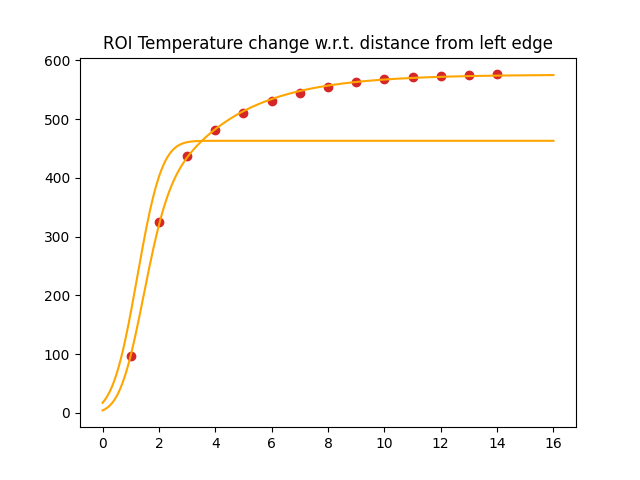

In [113]:
color = iter(cm.rainbow(np.linspace(0, 1, len(distances))))
distances = np.linspace(1, 14, 14)
time = result['PULSE_0s+1s_6A time']
plt.close(1)
fig1, ax1 = plt.subplots(num=1)
y = np.array([np.max(booga - 303) for booga in ROI_max_temps])
# egg = [ax.plot(time, booga - 303, label=f"x = {d}mm", c=c) for d, booga, c in zip(distances, max_temps, color)]

def negexpfitmodel(x, a, b, c):
    return a * (1 - np.exp(b * x)) + c

# def gaussianfitmodel(x, a, b, c):
#     return a * np.exp(-(x - b)**2 / (2 * c**2))

params, pcov = curve_fit(negexpfitmodel, distances, y, p0=(500, -0.4, 80))
xf = np.linspace(0, 16, 400)
print(params)
print(np.sqrt(np.diag(pcov)))

ax1.scatter(distances, y * occlusion(distances- 1.37722152, *falloff_params), color="tab:red")
ax1.set_title("ROI Temperature change w.r.t. distance from left edge")
ax1.plot(xf, negexpfitmodel(xf, *(params)) * occlusion(xf- 1.37722152, *falloff_params), c="orange")
ax1.plot(xf, occlusion(xf - 1.37722152, *falloff_params) * params[0], c="orange")
params[0]=1
# ax.plot(xf, gaussianfitmodel(xf, *(params2)), c="purple")

In [ ]:
chipmap_roi = []

xs, ys = np.meshgrid(distances, distances)

for x, y in tqdm(list(zip(xs.flatten(), ys.flatten()))):
    # pulse = ll.LaserPulse(CHIP, start=0, duration=1, position=(d, 22), power=6, sigma=EXPERIMENTAL_SIGMA)
    pulse = ll.LaserPulse(CHIP, start=0, duration=1, position=(x, y), power=6, sigma=EXPERIMENTAL_SIGMA, measure_target=True, target_modes=["MAX"], measure_timestep=0.01)
    sim.pulses = [pulse]
    result = sim.simulate(analyzers=[record_edge])
    chipmap_roi.append(result['PULSE_0s+1s_6A MAX 0'])

In [ ]:
pabo = np.array([np.max(row) for row in chipmap_roi])
chipmap_roi = pabo.reshape((len(distances), len(distances)))

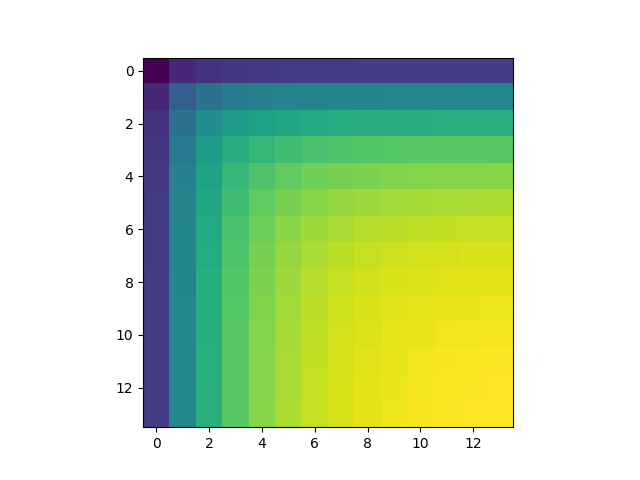

In [9]:
plt.close(3)
fig3, ax3 = plt.subplots(num=3)

ax3.imshow(chipmap_roi)

In [10]:
def occlusion(x, w, c=0):
    '''
    Using a domain-shifted razor blade model, return the proportion of laser power
    that will hit the edge of the chip given a laser with a certain waist and distance from the edge.

    parameters:

    x float, array[float]: The distance from the edge of the chip in millimeters

    w float: The gaussian beam waist w(z) in millimeters of the laser at the point of intersection with the chip.
             Related to FWHM by FWHM = w * sqrt(2 * np.log(2))

    c float: x-offset. Used to tune the position of the exact edge.

    returns:

    beamprop float: a number between 0 and 1 representing the effective laser power after occlusion.

    '''
    return 1 - 0.5 * (1 - erf(((x - w - c) * np.sqrt(2)) / w))

def expmodel(x, a, b):
    '''
    Exponential falloff fit function
    '''
    return a * np.exp(x * b)

def beam_falloff(x, a, b, w):
    '''
    Function to characterize lasing temperature response falloff w.r.t. distance from an edge
    '''
    return expmodel(x, a, b) * occlusion(x, w, 0)

<bound method Axes.imshow of <Axes: >>

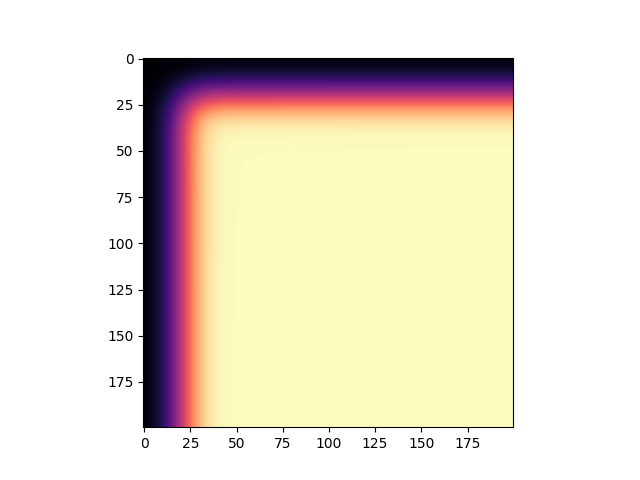

In [15]:
dist = np.linspace(0, 14, 200)
xs, ys = np.meshgrid(dist, dist)
plt.close(4)
fig4, ax4 = plt.subplots(num=4)

a, b, w = 17.266, -0.207, 1.394
ax4.imshow(negexpfitmodel(xs, *(params)) * negexpfitmodel(ys, *(params)) * occlusion(xs, w) * occlusion(ys, w), cmap="magma")
ax4.imshow

In [12]:
SILICON = sl.Material(diffusivity=88, emissivity=0.09, specific_heat=0.7, density=0.002329002)
CHIP = sl.SimGrid(32, 97, 0.03, use_spar=False,
                  spar_thickness=0.5, spar_width=1)

sim = sl.Simulation(CHIP, SILICON, duration=5, pulses=None, ambient_temp=300,
                    starting_temp=303, neumann_bc=False, 
                    edge_derivative=0, sample_framerate=24, intended_pbs=1,
                    dense_logging=False, timestep_multi=1, radiation=True, progress_bar=True, silent=False)

print(sim.TIMESTEP)

EXPERIMENTAL_SIGMA = 0.769941159 # beam sigma, mm

CENTER = (CHIP.CENTERPOINT)

0.00030918173122445626


In [13]:
laze = ll.LaserStrobe(CHIP, 0, 3, (16, 16), 2, parameterization=shapes.flick(8, 8, 24, 24, 3, 0.1), sigma=EXPERIMENTAL_SIGMA)
sim.pulses=[laze]

In [16]:
# sim.simulate()
ani = sim.animate(cmap="magma");
plt.close()
HTML(ani.to_jshtml())


ERROR:root:No information to animate.


AttributeError: 'NoneType' object has no attribute 'to_jshtml'

In [9]:
# power dependence on lasing
ROI_max_temps = []
pos = (8, 25)

powers = np.linspace(5, 10, 20)

color = iter(cm.rainbow(np.linspace(0, 1, len(powers))))

for p in powers:
    print(f"power: {p}")
    pulse = ll.LaserPulse(CHIP, start=0, duration=1, position=pos, power=p, sigma=EXPERIMENTAL_SIGMA, measure_target=True, target_modes=["MAX"])
    sim.pulses = [pulse]
    result = sim.simulate(analyzers=[])
    ROI_max_temps.append(result[fr'PULSE_0s+1s_{p}A MAX 0'])


power: 5.0
power: 5.2631578947368425
power: 5.526315789473684
power: 5.7894736842105265
power: 6.052631578947368
power: 6.315789473684211
power: 6.578947368421053
power: 6.842105263157895
power: 7.105263157894736
power: 7.368421052631579
power: 7.631578947368421
power: 7.894736842105263
power: 8.157894736842106
power: 8.421052631578947
power: 8.68421052631579
power: 8.947368421052632
power: 9.210526315789473
power: 9.473684210526315
power: 9.736842105263158
power: 10.0


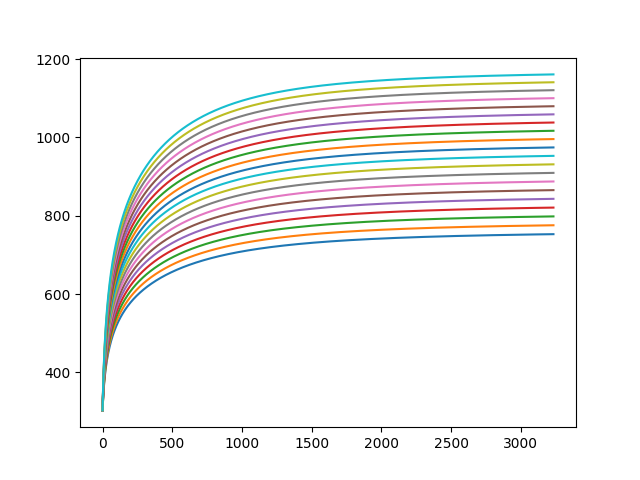

In [20]:
plt.close(8)

fig8, ax8 = plt.subplots(num=8)

for rmt in ROI_max_temps:
    ax8.plot(rmt)

# ax8.plot(powers, np.max(ROI_max_temps, axis=1))

plt.show()



In [ ]:
plt.close(2)
fig2, ax2 = plt.subplots(num=2)

def subexp(p, a, b, c):
    return a * (1 - np.exp((p - c) * b))

num = 200
p0 = (2, -1.2, 0)

color = iter(cm.rainbow(np.linspace(0, 1, num)))

for t, c in zip(np.linspace(1, 1.1, num), color):
    y = data.iloc[get_time_ind(t)][1:]
    ax2.plot(powers, y, color=c, markersize=1)
    # params, pcov = curve_fit(subexp, powers[50:], y[20:], p0=p0)
    # ax2.plot(subexp(powers, *params), color=c)

ax2.plot()